## <center>人工智能助力网络入侵检测</center>
#### <center><strong>杨航锋、范美华、付潇鹏</strong></center>

In [1]:
import json
import urllib
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import naive_bayes
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

### <center>特征抽取模块</center>

In [3]:
with open("样本-请注意不要传播-SQL+XSS.json", "r") as fp:
    bad_codes = fp.readlines()
    bad_requests = [json.loads(bad_query)["request"] for bad_query in bad_codes]
with open("white_sample.json", "r") as fp:
    good_codes = fp.readlines()
    good_requests = [json.loads(good_query)["request"] for good_query in good_codes]

good_query_list = [urllib.parse.unquote(requests) for requests in good_requests]
bad_query_list =  [urllib.parse.unquote(requests) for requests in bad_requests]
good_y = [1 for _ in good_query_list]
bad_y = [0 for _ in bad_query_list]
queries = good_query_list + bad_query_list
labels = good_y + bad_y


def get_ngrams(query):
    ngrams = []
    for i in range(len(query) - 3):
        ngrams.append(query[i: i+3])
    return ngrams

vectorizer = TfidfVectorizer(tokenizer=get_ngrams)
features = vectorizer.fit_transform(queries)

### <center>模型训练模块</center>

In [4]:
train_data, test_data, train_label, test_label = train_test_split(features, labels, test_size=0.2, random_state=0)

In [5]:
def plot(test_label, y_pred, model):
    font = {"color": "darkred",
            "size": 13, 
            "family" : "serif"}

    accs = accuracy_score(test_label, y_pred)
    fpr, tpr, _ = metrics.roc_curve(test_label,  y_pred)
    auc = metrics.roc_auc_score(test_label, y_pred)
    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label="{}, auc=".format(model)+str(auc), color='green', linewidth=2)
    ax.set_title("ROC curve", fontdict=font)
    leg = ax.legend(loc="best")
    text = leg.get_texts()
    _ = plt.setp(text, color="blue") 

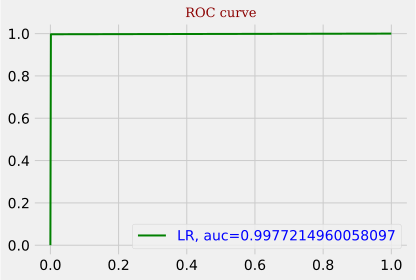

In [6]:
lr = LogisticRegression(solver="lbfgs")
lr.fit(train_data, train_label)
y_pred = lr.predict(test_data)
plot(test_label, y_pred, "LR")

In [50]:
target_names = ["bad_query", "good_query"]
print(classification_report(y_pred, test_label, target_names=target_names))

              precision    recall  f1-score   support

   bad_query       1.00      1.00      1.00      2040
  good_query       1.00      1.00      1.00       972

   micro avg       1.00      1.00      1.00      3012
   macro avg       1.00      1.00      1.00      3012
weighted avg       1.00      1.00      1.00      3012



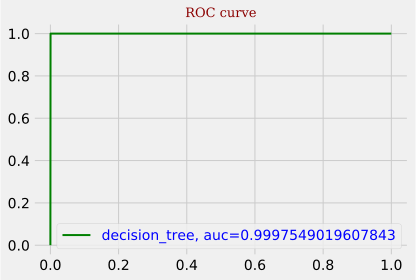

In [53]:
dt = DecisionTreeClassifier()
dt.fit(train_data, train_label)
y_pred = dt.predict(test_data)
plot(test_label, y_pred, "decision_tree")

In [54]:
target_names = ["bad_query", "good_query"]
print(classification_report(y_pred, test_label, target_names=target_names))

              precision    recall  f1-score   support

   bad_query       1.00      1.00      1.00      2039
  good_query       1.00      1.00      1.00       973

   micro avg       1.00      1.00      1.00      3012
   macro avg       1.00      1.00      1.00      3012
weighted avg       1.00      1.00      1.00      3012



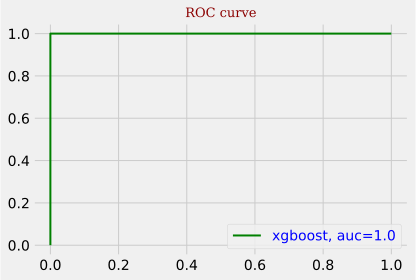

In [55]:
model = XGBClassifier()               
model.fit(train_data, train_label)            
y_pred = model.predict(test_data)
plot(test_label, y_pred, "xgboost")

In [56]:
target_names = ["bad_query", "good_query"]
print(classification_report(y_pred, test_label, target_names=target_names))

              precision    recall  f1-score   support

   bad_query       1.00      1.00      1.00      2040
  good_query       1.00      1.00      1.00       972

   micro avg       1.00      1.00      1.00      3012
   macro avg       1.00      1.00      1.00      3012
weighted avg       1.00      1.00      1.00      3012



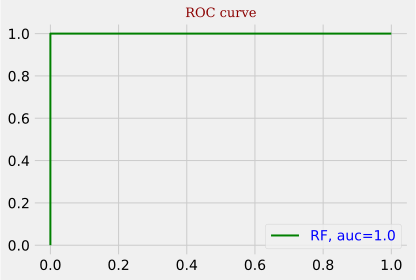

In [57]:
rcf = RandomForestClassifier(100)
rcf.fit(train_data, train_label)
y_pred = rcf.predict(test_data)
plot(test_label, y_pred, "RF")

In [58]:
target_names = ["bad_query", "good_query"]
print(classification_report(y_pred, test_label, target_names=target_names))

              precision    recall  f1-score   support

   bad_query       1.00      1.00      1.00      2040
  good_query       1.00      1.00      1.00       972

   micro avg       1.00      1.00      1.00      3012
   macro avg       1.00      1.00      1.00      3012
weighted avg       1.00      1.00      1.00      3012



### <center>再次测试模型</center>

In [104]:
bad_samples = ["/examples/jsp/colors/kernel/loadkernel.php?installpath=/etc/passwd\x00", 
               "/examples/jsp/cal/feedsplitter.php?format=../../../../../../../../../../etc/passwd\x00&debug=1"]

good_samples = ["post /data/dataservice.action?nocache=1534523920934 http/1.1\r\ncontent-length: 143\r\naccept-language: zh-cn,zh;q=0.8,zh-tw;q=0.7,zh-hk;q=0.5,en-us;q=0.3,en;q=0.2\r\naccept-encoding: gzip,deflate\r\nx-requested-with: xmlhttprequest\r\nconnection: close\r\naccept: text/html,application/xhtml xml,application/xml;q=0.9,*/*;q=0.8\r\nuser-agent: mozilla/5.0 (windows nt 10.0; win64; x64; rv:61.0) gecko/20100101 firefox/61.0\r\ncontent-type: application/x-www-form-urlencoded; charset=utf-8\r\nvpn-user: butian_rf1ah4pl\r\n\r\naction_name=update_role_auth') and 7883=7883 and ('cpyp'='cpyp&roleid=07180818003802850001&authids=0003;000301&type=10",
                "post /data/dataservice.action?nocache=1534523524940 http/1.1\r\ncontent-length: 509\r\naccept-language: zh-cn,zh;q=0.8,zh-tw;q=0.7,zh-hk;q=0.5,en-us;q=0.3,en;q=0.2\r\naccept-encoding: gzip,deflate\r\nx-requested-with: xmlhttprequest\r\nconnection: close\r\naccept: text/html,application/xhtml xml,application/xml;q=0.9,*/*;q=0.8\r\nuser-agent: mozilla/5.0 (windows nt 10.0; win64; x64; rv:61.0) gecko/20100101 firefox/61.0\r\ncontent-type: application/x-www-form-urlencoded; charset=utf-8\r\nvpn-user: butian_rf1ah4pl\r\n\r\nmername=17801459189 waitfor delay '0:0:5'--&selfname=1&industrytype=12&kk=00&nn=--请选择--&region_province=110000&provincename=北京&region_city=110100&cityname=北京市&region_district=110102&valiregion=&areaname=西城区&detailedaddress=1&faxnum=&email=1@qq.com&linkman=a&cellphone=17801459189&com_introduce=<p>111<br/></p>&companylogofile=&companylogoid=&joinlimit=1&action_name=company_baseinfo_updatea"]

In [95]:
bad_features = vectorizer.transform(bad_samples)

In [96]:
lr.predict(bad_features) # 0代表负样本，1代表正样本

array([0, 0])

In [105]:
good_features = vectorizer.transform(good_samples)

In [106]:
lr.predict(good_features)

array([1, 1])